# Подзапросы

Подзапросы используются, когда нужен результат выполнения одного запроса в следующем запросе. Выглядит подзапрос, как запрос **SELECT**, содержащийся в другом SQL-выражении.

## Классификация

*По тому, сколько строк и столбцов возвращает:*

- Скалярный: 1 столбец , 0-1 строка.

- Список значений: 1 столбец, 0-N строк.

- «Таблица»: 1-M столбцов, 0-N строк.

*По связи с внешним запросом:*

- Коррелированный (связанный) – использует в себе поля внешнего запроса.

- Некоррелированный (несвязанный) – самостоятельный запрос, не использующий поля внешнего запроса.


## Подзапросы в разных частях запроса

### Подзапросы в **SELECT**

Могут быть *только скалярные*. Как коррелированные, так и нет.

Например, выведем всю информацию о продуктах, добавив фильтр по тому, выше или ниже средняя цена, чем 16000.

    SELECT p.*,
    CASE WHEN p.product_id in (SELECT prices.product_id FROM prices group by prices.product_id having avg(prices.price) >16000 )
        THEN 'Средняя цена выше 16000'
        ELSE 'Средняя цена ниже 16000'
    END AS avg_filter
    FROM products p;
    
Этот запрос является некоррелированным.

Используем коррелированный запрос, чтобы вывести количество изменений цены для каждого продукта:

    SELECT products.name, (
        SELECT COUNT(*)
        FROM prices
        WHERE prices.product_id = products.product_id
        group by prices.product_id) AS sale_cnt
    FROM products;

### Подзапросы во **FROM**

*Только некоррелированные*.

Например, вывести по каждому продукту последнюю дату покупки и магазин, в котором покупка была совершена:

    SELECT s.product_id, s.store_id, s.sale_date
    FROM (
        SELECT
            product_id,
            store_id,
            sale_date,
            ROW_NUMBER() OVER (PARTITION BY product_id ORDER BY sale_date DESC) RN
        FROM sales
        ) S
    WHERE S.RN = 1;


    
###  **WHERE**

Например, некоррелированный подзапрос.

Выведем всю информацию о цене продуктов бренда 'Жора':
    
    SELECT *
    FROM prices
    WHERE prices.product_id IN (SELECT p.product_id FROM products p WHERE p.brand = 'Жора' );

Коррелированный подзапрос: цена на какое количество продуктов достигла максимума в каждый из дней изменения цены? Подзапрос: для каждого product_id выбираем дату установки наибольшей цены. Затем в основном запросе группируем по дате и считаем количество продуктов, изменивших цену в этот день (фактически - получивших самую высокую цену).

    SELECT count(p.product_id), p.start_date
    FROM prices p
    WHERE (p.product_id, p.start_date) in (
        SELECT distinct P_OTHER.product_id,
        last_value(P_OTHER.start_date) over (partition by P_OTHER.product_id order by P_OTHER.price ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING)
        FROM prices P_OTHER
        WHERE P.product_id = P_OTHER.product_id)
    group by p.start_date
    order by p.start_date;


### Подзапросы в HAVING

В HAVING – аналогично WHERE.

Например, продукты, у которых чаще всего менялась цена:

    SELECT product_id, COUNT(*) CNT
    FROM prices
    GROUP BY product_id
    HAVING COUNT(*) = (
        SELECT MAX(CNT)
        FROM (
            SELECT COUNT(*) CNT
            FROM prices
            GROUP BY product_id
        ) p
    );



### CTE

CTE позволяет выносить подзапросы отдельно от основного запроса.
Если используете CTE – легче понять, что происходит в основном запросе. CTE в базе не сохраняется. Нужно вызывать WITH всегда, когда вызываете запрос с CTE.

Пример CTE

    WITH p_cnt AS (SELECT MAX(CNT) CNT
               FROM (SELECT COUNT(*) CNT
                     FROM prices
                     GROUP BY product_id) p)

    SELECT product_id, COUNT(*) CNT
    FROM prices
    GROUP BY product_id
    HAVING COUNT(*) =  (SELECT CNT FROM p_cnt);

## **JOIN**

JOIN-соединения – операции горизонтального соединения данных
Операторы соединения входят в раздел FROM SQL запросов. Операции горизонтального соединения таблицы с другими таблицами используются для того, чтобы получить из них недостающие данные. 

Есть пять типов соединения:

**JOIN** (**INNER JOIN**)  – Из строк левой таблицы и правой таблицы объединяются и возвращаются только те строки, по которым выполняются условия соединения.

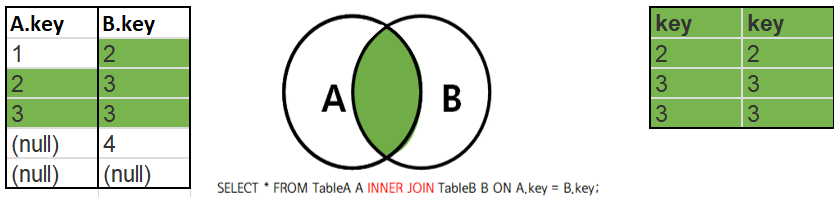

**LEFT JOIN** (**LEFT OUTER JOIN**) – Возвращаются все строки левой таблицы (ключевое слово LEFT). Данными правой таблицы дополняются только те строки левой таблицы, для которых выполняются условия соединения. Для недостающих данных вместо строк правой таблицы вставляются NULL-значения.

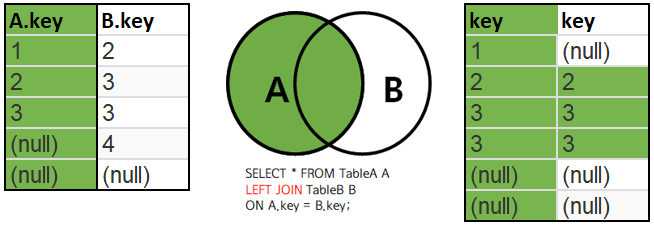

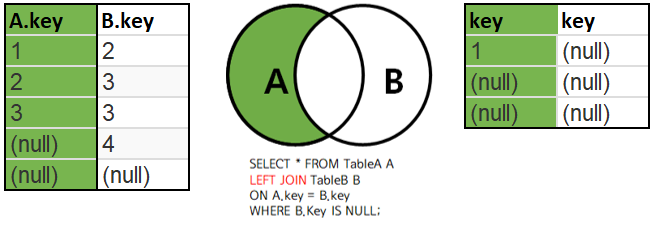

**RIGHT JOIN** (**RIGHT OUTER JOIN**) – Возвращаются все строки правой таблицы (ключевое слово RIGHT). Данными левой таблицы дополняются только те строки правой таблицы, для которых выполняются условия соединения. Для недостающих данных вместо строк левой таблицы вставляются NULL-значения.

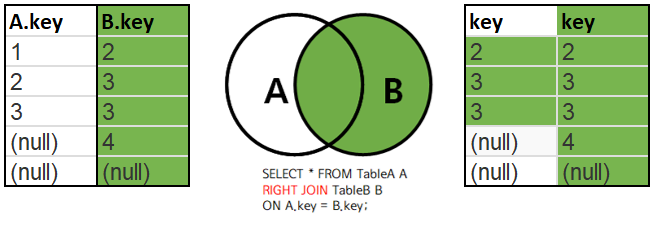

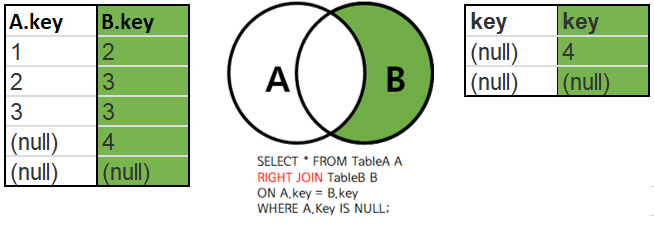

**FULL JOIN** (**FULL OUTER JOIN**) – Возвращаются все строки левой таблицы и правой таблицы. Если для строк левой таблицы и правой таблицы выполняются условия соединения, то они объединяются в одну строку. Для строк, для которых не выполняются условия соединения, NULL-значения вставляются на место левой таблицы, либо на место правой таблицы, в зависимости от того данных какой таблицы в строке не имеется.

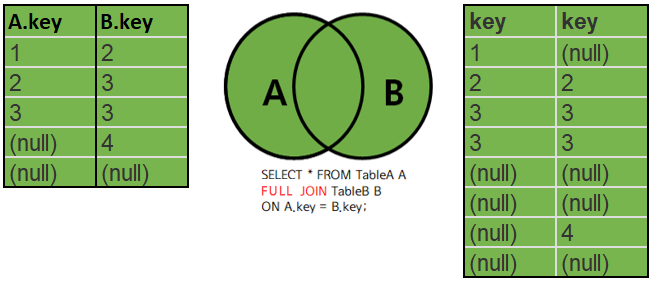

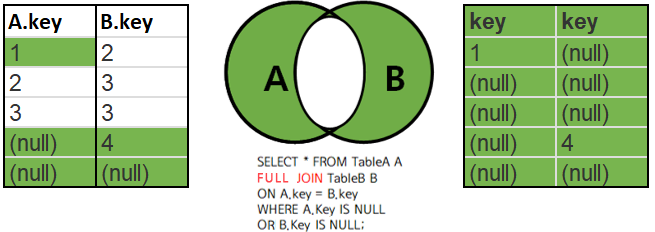

**CROSS JOIN** – Объединение каждой строки левой таблицы со всеми строками правой таблицы. Этот вид соединения иногда называют декартовым произведением.

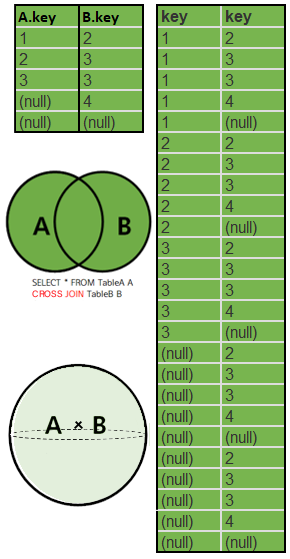

При написании запросов часто используются только краткий синтаксис, по причинам:
- Это короче и не засоряет запрос лишними словами;
- По словам LEFT, RIGHT, FULL и CROSS и так понятно о каком соединении идет речь, так же и в случае просто JOIN;
- Слова INNER и OUTER считаются в данном случае ненужными рудиментами, которые больше путают начинающих.

### Примеры

**JOIN**

Хотим узнать, сколько покупок совершили за февраль 2020 года пользователи с именем Евпатий подневно.

    SELECT sales.sale_date, count(*)
    FROM sales
    JOIN customers c
    ON sales.customer_id = c.customer_id
    WHERE 
        sales.sale_date BETWEEN '2020-02-01' AND '2020-02-29'
        AND c.name = 'Евпатий'
    GROUP BY sales.sale_date

**LEFT JOIN**

Хотим узнать, какие пользователи купили продукт с product_id = 10 28 декабря 2019 года, а какие нет.

    SELECT DISTINCT
        c.customer_id,
        c.name,
        c.surname,
        s.customer_id IS NOT NULL as purchase
    FROM customers c
    LEFT JOIN (
		SELECT *
		FROM sales
		WHERE
            product_id = 10
            AND sale_date = '2019-12-28'
		) s
    ON c.customer_id = s.customer_id
	ORDER BY purchase DESC
    

**RIGHT JOIN**

    практически не используется

**FULL JOIN**

Хотим вывести всех клиентов и все покупки за 28 декабря 2019, даже если пользователь не совершал покупок в этот день и даже если покупка совершена неизвестным клиентом.

    SELECT DISTINCT
        c.customer_id,
        c.name,
        c.surname,
		s.product_id,
		c.customer_id IS NOT NULL as client_known,
        s.sale_id IS NOT NULL as purchase
    FROM customers c
    FULL JOIN (
		SELECT *
		FROM sales
		WHERE sale_date = '2019-12-28'
	) s
    ON c.customer_id = s.customer_id
	ORDER BY purchase DESC, client_known
    
### Джоин таблицы на саму себя

Хотим составить пары всех клиентов, исключив пары с самим собой.

    SELECT c1.name, c1.surname, c2.name, c2.surname
    FROM customers c1 JOIN customers c2 ON c1.customer_id != c2.customer_id


## **JOIN** vs подзапрос

Основные отличия:

1. План запроса – "с какой скоростью выполнится запрос?".

2. Читаемость.

## UNION

**UNION** – операция вертикального объединения результатов запросов. Соответственно количество колонок в каждом запросе должно быть одинаковым, а также должны быть совместимыми и типы этих колонок.

**UNION ALL** - Возвращаются все строки из обоих наборов.

**UNION** - Возвращаются только уникальные строки двух наборов.

**EXCEPT** - Возвращаются уникальные строки верхнего набора, которые отсутствуют в нижнем наборе.

**INTERSECT** -	Возвращаются только уникальные строки, присутствующие в обоих наборах.

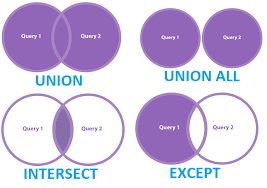


### Пример

    SELECT 'кол-во продуктов' as name, count(distinct product_id) cnt
    FROM products
    
    UNION
    
    SELECT 'кол-во зарегистрированных покупателей' as name, count(distinct customer_id) cnt
    FROM customers
    
    ORDER BY cnt

